## The Problem: compute average sales price per sqft for recently sold houses in Berkeley

#### Note to self

Spent 90 minutes installing geopandas, pandana, and osmnx.  The way I finally got it to work was using pip and installing dependencies using brew.  Avoid conda-forge.

In [2]:
import pandas as pd
import geopandas as gpd
import pandana as pdna
import osmnx as ox
from shapely.geometry import Point, Polygon
%matplotlib inline

### Read in the data we want to aggregate - a file of recent sales on Redfin in Berkeley which was downloaded from redfin.com

In [3]:
df = pd.read_csv("redfin_2017-09-20-14-39-25.csv")
df = df.dropna(subset=['$/SQUARE FEET', 'ADDRESS'])
df = df[df['$/SQUARE FEET'] < 1500]
df = df[df['$/SQUARE FEET'] > 380]
df = df[df['PROPERTY TYPE'] == 'Single Family Residential']
df = df.set_index("ADDRESS")
df["ZIP"] = df.ZIP.apply(lambda x: x[:5])
print len(df)
df.head()

227


SALE TYPE       SOLD DATE              PROPERTY TYPE  \
ADDRESS                                                                  
1834 63Rd St      PAST SALE   April-18-2017  Single Family Residential   
1839 63Rd St      PAST SALE    July-28-2017  Single Family Residential   
1613 5th St       PAST SALE  August-18-2017  Single Family Residential   
1946 Yosemite Rd  PAST SALE   April-26-2017  Single Family Residential   
2504 Grant St     PAST SALE     May-23-2017  Single Family Residential   

                      CITY STATE    ZIP    PRICE  BEDS  BATHS  \
ADDRESS                                                         
1834 63Rd St      Berkeley    CA  94703   940000   2.0    1.5   
1839 63Rd St      Berkeley    CA  94703   860000   2.0    1.0   
1613 5th St       Berkeley    CA  94710   900000   2.0    1.0   
1946 Yosemite Rd  Berkeley    CA  94707  1525000   3.0    2.5   
2504 Grant St     Berkeley    CA  94703   843000   3.0    3.0   

                          LOCATION     ...      STATUS  \
ADDRESS                                ...               
1834 63Rd St              Le Conte     ...        Sold   
1839 63Rd St              Santa Fe     ...        Sold   
1613 5th St          West Berkeley     ...        Sold   
1946 Yosemite Rd     Thousand Oaks     ...        Sold   
2504 Grant St     Central Berkeley     ...        Sold   

                  NEXT OPEN HOUSE START TIME  NEXT OPEN HOUSE END TIME  \
ADDRESS                                                                  
1834 63Rd St                             NaN                       NaN   
1839 63Rd St                             NaN                       NaN   
1613 5th St                              NaN                       NaN   
1946 Yosemite Rd                         NaN                       NaN   
2504 Grant St                            NaN                       NaN   

                                                                URL  \
ADDRESS                                                               
1834 63Rd St      http://www.redfin.com/CA/Berkeley/1834-63rd-St...   
1839 63Rd St      http://www.redfin.com/CA/Berkeley/1839-63rd-St...   
1613 5th St       http://www.redfin.com/CA/Berkeley/1613-5th-St-...   
1946 Yosemite Rd  http://www.redfin.com/CA/Berkeley/1946-Yosemit...   
2504 Grant St     http://www.redfin.com/CA/Berkeley/2504-Grant-S...   

                              SOURCE      MLS# FAVORITE  INTERESTED  \
ADDRESS                                                               
1834 63Rd St      EBRD/CCAR/Bay East  40771117        N           N   
1839 63Rd St      EBRD/CCAR/Bay East  40787457        N           Y   
1613 5th St       EBRD/CCAR/Bay East  40790651        N           Y   
1946 Yosemite Rd  EBRD/CCAR/Bay East  40775608        N           Y   
2504 Grant St     EBRD/CCAR/Bay East  40779589        N           Y   

                   LATITUDE   LONGITUDE  
ADDRESS                                  
1834 63Rd St      37.847825 -122.269773  
1839 63Rd St      37.848338 -122.269522  
1613 5th St       37.873378 -122.300281  
1946 Yosemite Rd  37.896316 -122.276743  
2504 Grant St     37.862795 -122.274578  

[5 rows x 26 columns]

In [4]:
pd.set_option('display.max_colwidth', 100)
df.sort_values('$/SQUARE FEET', ascending=False).head().URL

ADDRESS
1157 Virginia St           http://www.redfin.com/CA/Berkeley/1157-Virginia-St-94702/home/1883152
1253 Hearst Ave             http://www.redfin.com/CA/Berkeley/1253-Hearst-Ave-94702/home/1460574
1326 Cornell Ave           http://www.redfin.com/CA/Berkeley/1326-Cornell-Ave-94702/home/1459089
992 SANTA BARBARA Rd    http://www.redfin.com/CA/Berkeley/992-Santa-Barbara-Rd-94707/home/705927
2932 Pine Ave                  http://www.redfin.com/CA/Berkeley/2932-Pine-Ave-94705/home/655148
Name: URL, dtype: object

In [5]:
df.sort_values('$/SQUARE FEET').head().URL

ADDRESS
6301 Herzog St                                          http://www.redfin.com/CA/Oakland/6301-Herzog-St-94608/home/531569
2800 Martin Luther King Jr Way    http://www.redfin.com/CA/Berkeley/2800-Martin-Luther-King-Junior-Way-94703/home/2000727
635 Santa Barbara Rd                             http://www.redfin.com/CA/Berkeley/635-Santa-Barbara-Rd-94707/home/700747
3046 Stanton St                                      http://www.redfin.com/CA/Berkeley/3046-Stanton-St-94702/home/1776868
6452 Regent St                                         http://www.redfin.com/CA/Oakland/6452-Regent-St-94618/home/1546253
Name: URL, dtype: object

### This plot sucks - is there a way to show a basemap that's easy?

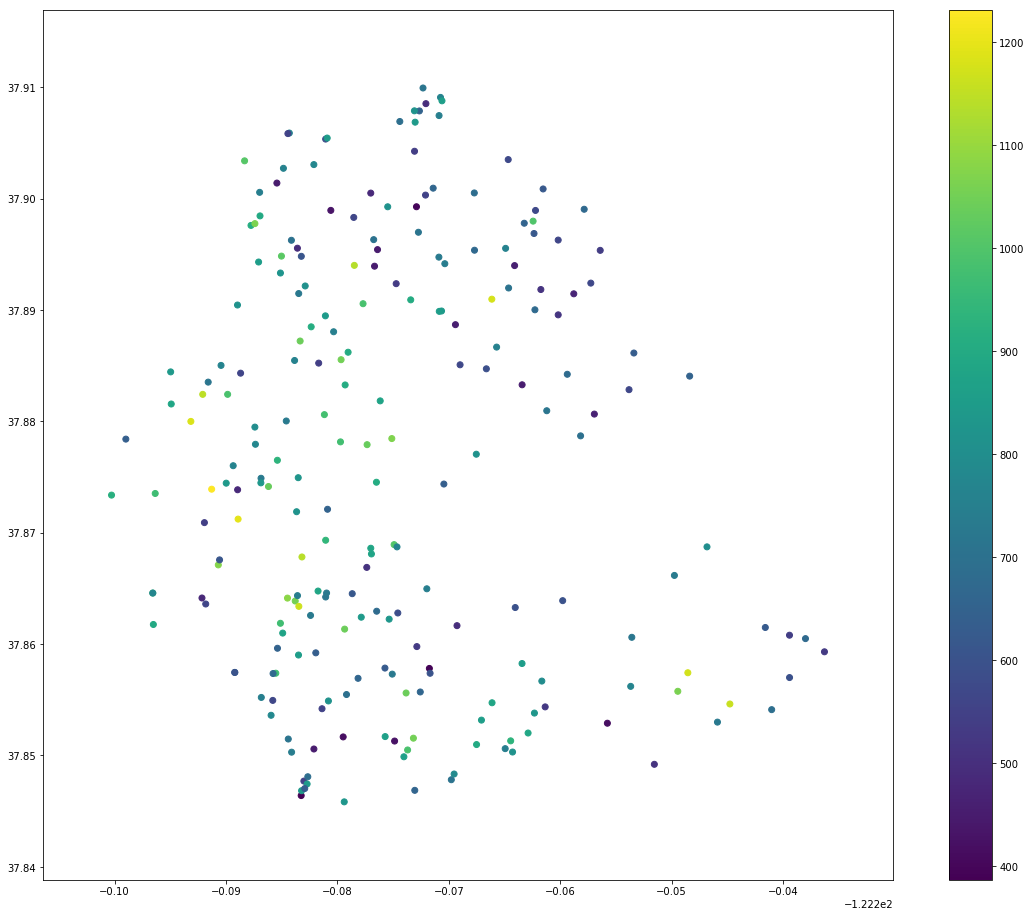

In [6]:
gdf = gpd.GeoDataFrame(df, geometry=[Point(row.LONGITUDE, row.LATITUDE) for _, row in df.iterrows()])
gdf.plot(column='$/SQUARE FEET', legend=True, figsize=(20, 16))

### Our first average - just use Pandas to do a group by ZIP and quantile

In [7]:
s = df.groupby('ZIP')['$/SQUARE FEET'].mean().sort_values(ascending=False)
s.head(10)

ZIP
94609    856.000000
94706    839.642857
94702    817.214286
94703    790.270270
94705    773.647059
94710    745.700000
94707    742.577778
94608    688.875000
94704    662.833333
94709    662.000000
Name: $/SQUARE FEET, dtype: float64

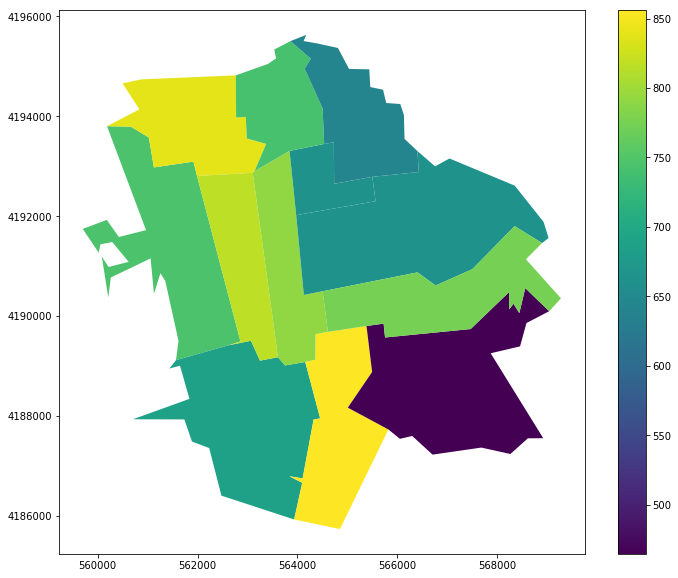

In [8]:
gdf = gpd.GeoDataFrame.from_file("zips.json")
gdf["median_price_per_sqft"] = s.loc[gdf.ZIP_CODE_5].values
gdf[~gdf.median_price_per_sqft.isnull()].plot(column="median_price_per_sqft", legend=True, figsize=(12, 10))

### 94609 has 5 houses, all of which were high dollar.  Technically all the houses were in Oakland, and Bushrod is one of the hottest neighborhoods in the country

In [9]:
print df.ZIP.value_counts()
df[df.ZIP == "94609"].transpose()

94707    45
94702    42
94703    37
94708    36
94705    17
94706    14
94710    10
94608     8
94704     6
94709     5
94609     5
94618     2
Name: ZIP, dtype: int64


ADDRESS                                                                        649 65Th St  \
SALE TYPE                                                                        PAST SALE   
SOLD DATE                                                                      May-12-2017   
PROPERTY TYPE                                                    Single Family Residential   
CITY                                                                               Oakland   
STATE                                                                                   CA   
ZIP                                                                                  94609   
PRICE                                                                              1430000   
BEDS                                                                                     3   
BATHS                                                                                    2   
LOCATION                                                                         N.Oakland   
SQUARE FEET                                                                           1758   
LOT SIZE                                                                              4800   
YEAR BUILT                                                                            1918   
DAYS ON MARKET                                                                         131   
$/SQUARE FEET                                                                          813   
HOA/MONTH                                                                              NaN   
STATUS                                                                                Sold   
NEXT OPEN HOUSE START TIME                                                             NaN   
NEXT OPEN HOUSE END TIME                                                               NaN   
URL                         http://www.redfin.com/CA/Oakland/649-65th-St-94609/home/531631   
SOURCE                                                                  EBRD/CCAR/Bay East   
MLS#                                                                              40775107   
FAVORITE                                                                                 Y   
INTERESTED                                                                               Y   
LATITUDE                                                                           37.8503   
LONGITUDE                                                                         -122.264   
geometry                                            POINT (-122.2642748 37.85031110000001)   

ADDRESS                                                                         580 66Th St  \
SALE TYPE                                                                         PAST SALE   
SOLD DATE                                                                      June-12-2017   
PROPERTY TYPE                                                     Single Family Residential   
CITY                                                                                Oakland   
STATE                                                                                    CA   
ZIP                                                                                   94609   
PRICE                                                                               1300000   
BEDS                                                                                      3   
BATHS                                                                                   2.5   
LOCATION                                                                    Berkeley Border   
SQUARE FEET                                                                            1463   
LOT SIZE                                                                                NaN   
YEAR BUILT                                                                             2008   
DAYS ON MARKET                       

This is the traditional GIS way of doing things, but has severe boundary problems, and in cases like this, where there are only 350 sold houses, we probably need overlapping buffers to "smooth things out" rather than mutually exclusive shapes like zip codes.

*This is the purpose of pandana, to do parameterized aggregations along the street network.*

### Let's get the street network for Berkeley using osmnx

In [10]:
G = ox.graph_from_place('Berkeley, California, USA')

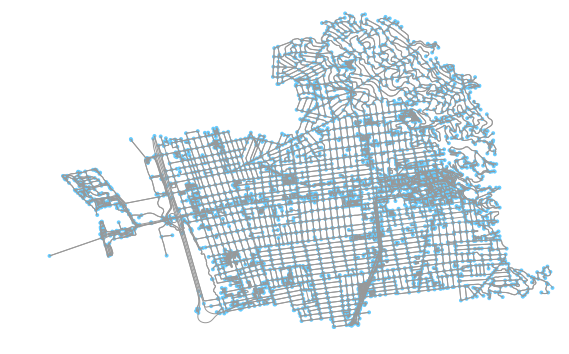

(<matplotlib.figure.Figure at 0x12c8b4950>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12950a450>)

In [11]:
ox.plot_graph(G)

### We want it as a geodataframe

In [12]:
nodes, edges = ox.save_load.graph_to_gdfs(G)
# since we're in lat/lng, we need the full precision (something in osmnx lowers the precision?)
nodes["x"] = [p.x for p in nodes.geometry.values]
nodes["y"] = [p.y for p in nodes.geometry.values]
nodes["point_geometry"] = nodes.geometry
nodes.head()

highway     osmid  ref           x          y  \
34351114     NaN  34351114  NaN -122.246530  37.866153   
34485314     NaN  34485314  NaN -122.247001  37.866140   
35719055     NaN  35719055  NaN -122.244383  37.859827   
35719092     NaN  35719092  NaN -122.247074  37.867541   
35719098     NaN  35719098  NaN -122.248403  37.866058   

                                 geometry                   point_geometry  
34351114  POINT (-122.2465302 37.8661529)  POINT (-122.2465302 37.8661529)  
34485314  POINT (-122.2470015 37.8661398)  POINT (-122.2470015 37.8661398)  
35719055  POINT (-122.2443826 37.8598274)  POINT (-122.2443826 37.8598274)  
35719092  POINT (-122.2470736 37.8675411)  POINT (-122.2470736 37.8675411)  
35719098  POINT (-122.2484031 37.8660581)  POINT (-122.2484031 37.8660581)

In [13]:
edges.head()

access area bridge  \
0    NaN  NaN    NaN   
1    NaN  NaN    NaN   
2    NaN  NaN    NaN   
3    NaN  NaN    NaN   
4    NaN  NaN    NaN   

                                                                                              geometry  \
0  LINESTRING (-122.2726539 37.8884334, -122.2725838 37.8884624, -122.2725262 37.8884722, -122.2725...   
1  LINESTRING (-122.2726539 37.8884334, -122.2726977 37.8883963, -122.2727302 37.8883495, -122.2731...   
2                LINESTRING (-122.2726539 37.8884334, -122.272767 37.8885487, -122.2726036 37.8888229)   
3  LINESTRING (-122.3111831 37.8651709, -122.3111414 37.8651442, -122.3110547 37.8651277, -122.3107...   
4               LINESTRING (-122.3111831 37.8651709, -122.3111724 37.8652928, -122.3112926 37.8655503)   

       highway  key lanes     length maxspeed              name  oneway  \
0     tertiary    0     3  24.927042   25 mph    Hopkins Street   False   
1     tertiary    0     3  91.657912   25 mph    Hopkins Street   False   
2      footway    0   NaN  49.907068      NaN               NaN   False   
3  residential    0   NaN  41.880507      NaN  Marina Boulevard    True   
4  residential    0   NaN  44.101629      NaN  Marina Boulevard    True   

                    osmid  ref service tunnel          u           v width  
0               234074080  NaN     NaN    NaN  348192780   239669505   NaN  
1  [234074080, 234074081]  NaN     NaN    NaN  348192780    53019172   NaN  
2               185454959  NaN     NaN    NaN  348192780  1960546513   NaN  
3                22372575  NaN     NaN    NaN   53116941   240448833   NaN  
4                22372574  NaN     NaN    NaN   53116941   240448850   NaN

### osmnx has pandana connectivity out of the box (though I think by accident)

In [14]:
net = pdna.Network(nodes.x, nodes.y, edges.u, edges.v, edges[["length"]])
net.precompute(4000)

### assign each sold house to it's nearest street intersection

In [15]:
df["node_ids"] = net.get_node_ids(df.LONGITUDE, df.LATITUDE)
df.node_ids.head()

ADDRESS
1834 63Rd St          56063268
1839 63Rd St          53122202
1613 5th St         1979167530
1946 Yosemite Rd      53082795
2504 Grant St         53020966
Name: node_ids, dtype: int64

### add the observations to the pandana network so that we can parameterize the aggregation

In [16]:
net.set(df.node_ids, variable=df["$/SQUARE FEET"], name="$/SQUARE FEET")

### get the median price/sqft at different radii

In [17]:
for dist in [500, 1000, 2000, 3000, 4000]:
    nodes["%dmeters" % dist] = net.aggregate(dist, type="mean", decay="flat", name="$/SQUARE FEET")
nodes.head()

highway     osmid  ref           x          y  \
34351114     NaN  34351114  NaN -122.246530  37.866153   
34485314     NaN  34485314  NaN -122.247001  37.866140   
35719055     NaN  35719055  NaN -122.244383  37.859827   
35719092     NaN  35719092  NaN -122.247074  37.867541   
35719098     NaN  35719098  NaN -122.248403  37.866058   

                                 geometry                   point_geometry  \
34351114  POINT (-122.2465302 37.8661529)  POINT (-122.2465302 37.8661529)   
34485314  POINT (-122.2470015 37.8661398)  POINT (-122.2470015 37.8661398)   
35719055  POINT (-122.2443826 37.8598274)  POINT (-122.2443826 37.8598274)   
35719092  POINT (-122.2470736 37.8675411)  POINT (-122.2470736 37.8675411)   
35719098  POINT (-122.2484031 37.8660581)  POINT (-122.2484031 37.8660581)   

          500meters  1000meters  2000meters  3000meters  4000meters  
34351114      736.0  720.666667  804.833333  725.086957  749.257426  
34485314      736.0  720.666667  788.846154  717.183673  746.375000  
35719055      898.5  904.833333  730.333333  731.050000  722.902174  
35719092      736.0  720.666667  802.083333  711.446809  751.524272  
35719098      736.0  720.666667  763.062500  720.875000  751.954955

In [18]:
nodes[nodes["2000meters"] > 0].plot(figsize=(30, 25), column="2000meters", legend=True)

In [19]:
nodes["tmp"] = net.aggregate(2000, type="count", decay="flat", name="$/SQUARE FEET")
nodes.plot(figsize=(30, 25), column="tmp", legend=True)

## A degenerate case of pandana is a traditional cumulative accessibility measure

If you switch the average to a sum, and the decay to linear, you can compute the sum of an attribute with a decay so that things that are futher away could less.  Normally we'd be summing population or jobs, but the closest proxy for the small dataset we're using is bedrooms, so we sum bedrooms with a linear decay.

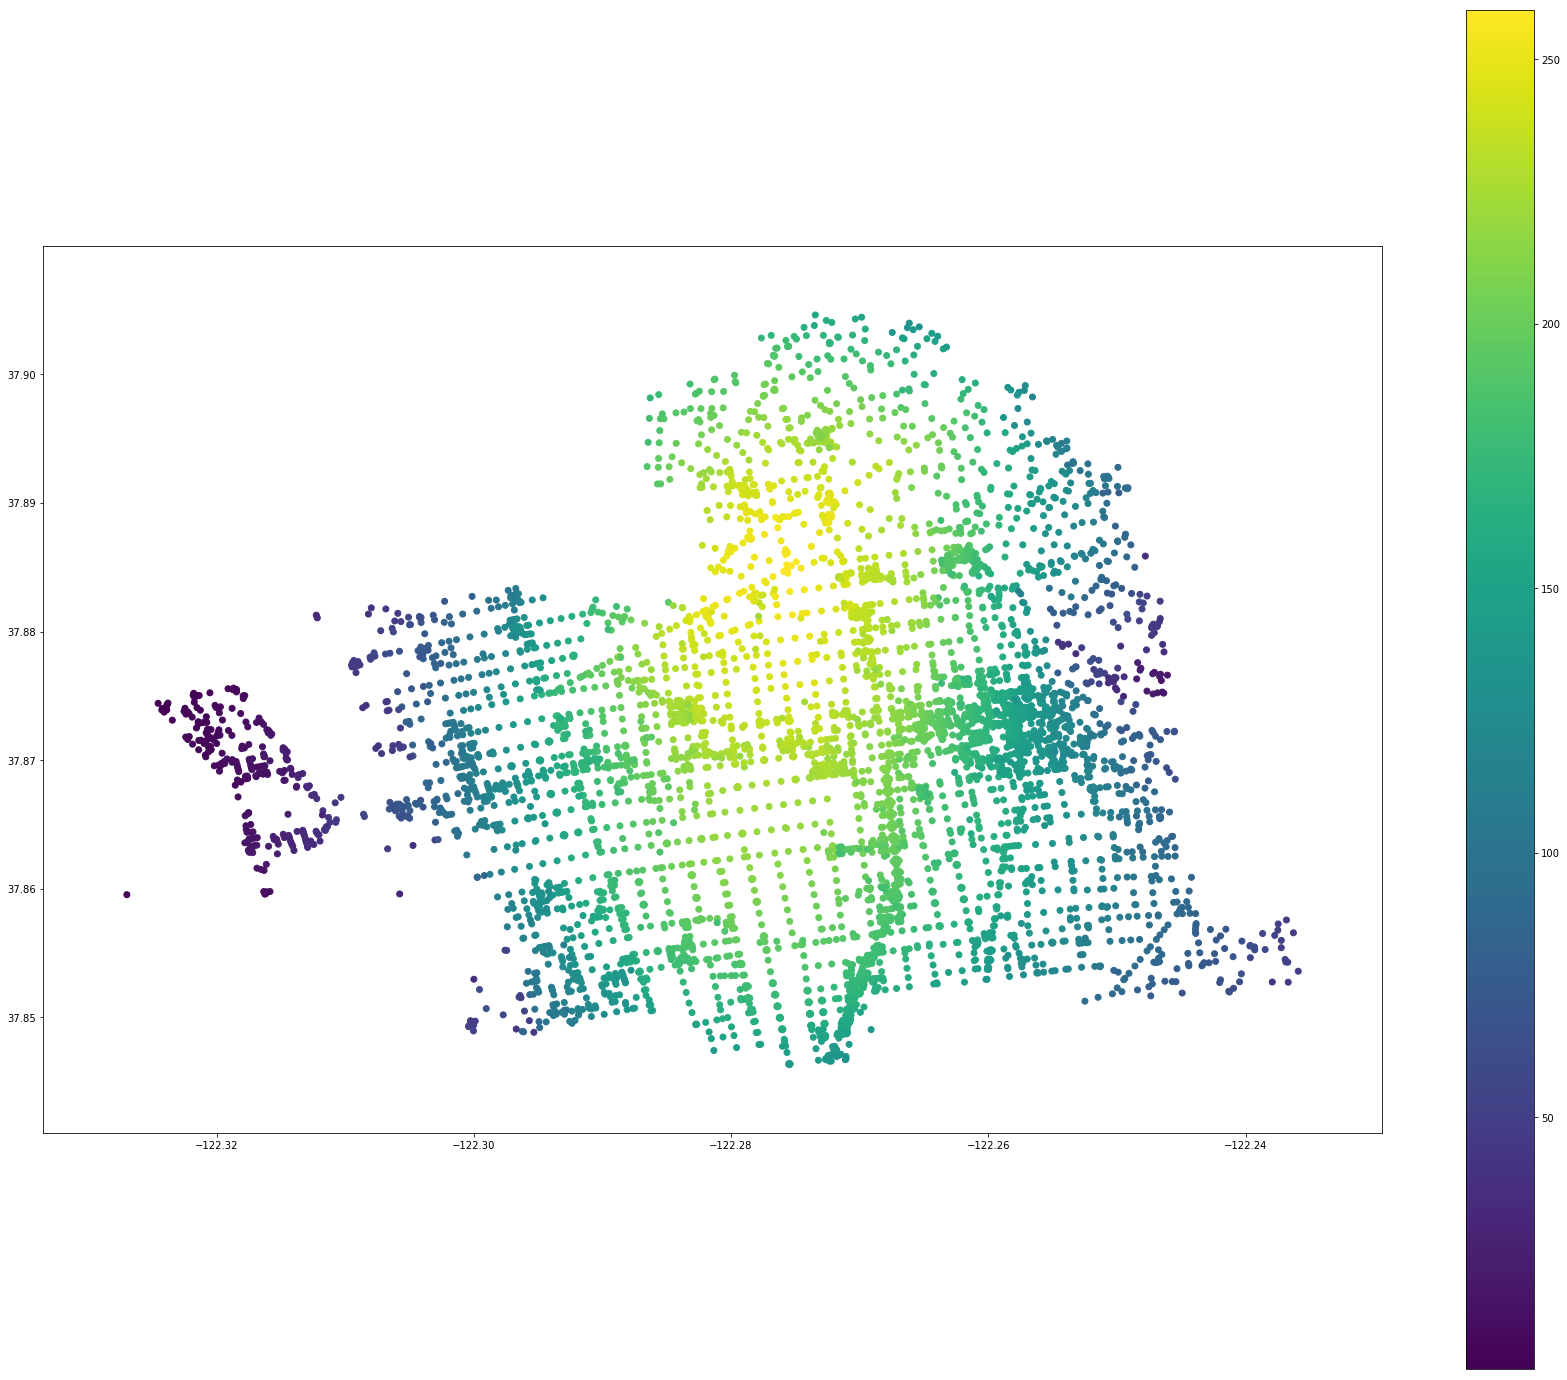

In [20]:
net.set(df.node_ids, variable=df.BEDS, name="beds")
nodes["tmp"] = net.aggregate(4000, type="sum", decay="linear", name="beds")
nodes.plot(figsize=(30, 25), column="tmp", legend=True)

## Do a voronoi tesselation

This is what we're really aggregating - all the data in the space that is nearest to a node gets assigned to that node, then we do the aggregation.  We could, in theory, apply the network down to access-egress on a parcel or building, but in practice our "zone system" is the space that is closest to each street node.

In [21]:
# pytess gives you the polygon back whereas the scipy doesn't
import pytess

points = [(p.x, p.y) for p in nodes.geometry.values]
polys = pytess.voronoi(points)
# not sure what's up with this
polys = polys[:len(nodes)]
# drop the point, turn into shapely poly
nodes["voronoi_geometry"] = [Polygon(p[1]) for p in polys]

## Display both the tesselation and the street intersections on top

In [22]:
nodes["geometry"] = nodes["voronoi_geometry"]
ax = nodes.plot(figsize=(30, 25), column="tmp", legend=True)
ax.set_ylim([37.85, 37.89])
ax.set_xlim([-122.29, -122.24])
nodes["geometry"] = nodes["point_geometry"]
nodes.plot(ax=ax, color='black', alpha=0.5)

### Show a buffer for a single point

We're aggregating a buffer around each intersection.  Here's an example buffer.  If network connectivity were "perfect," the yellow area would be a circle.  It's not perfect, which is the whole reason we're doing network aggregations instead of "crow flies" distances.

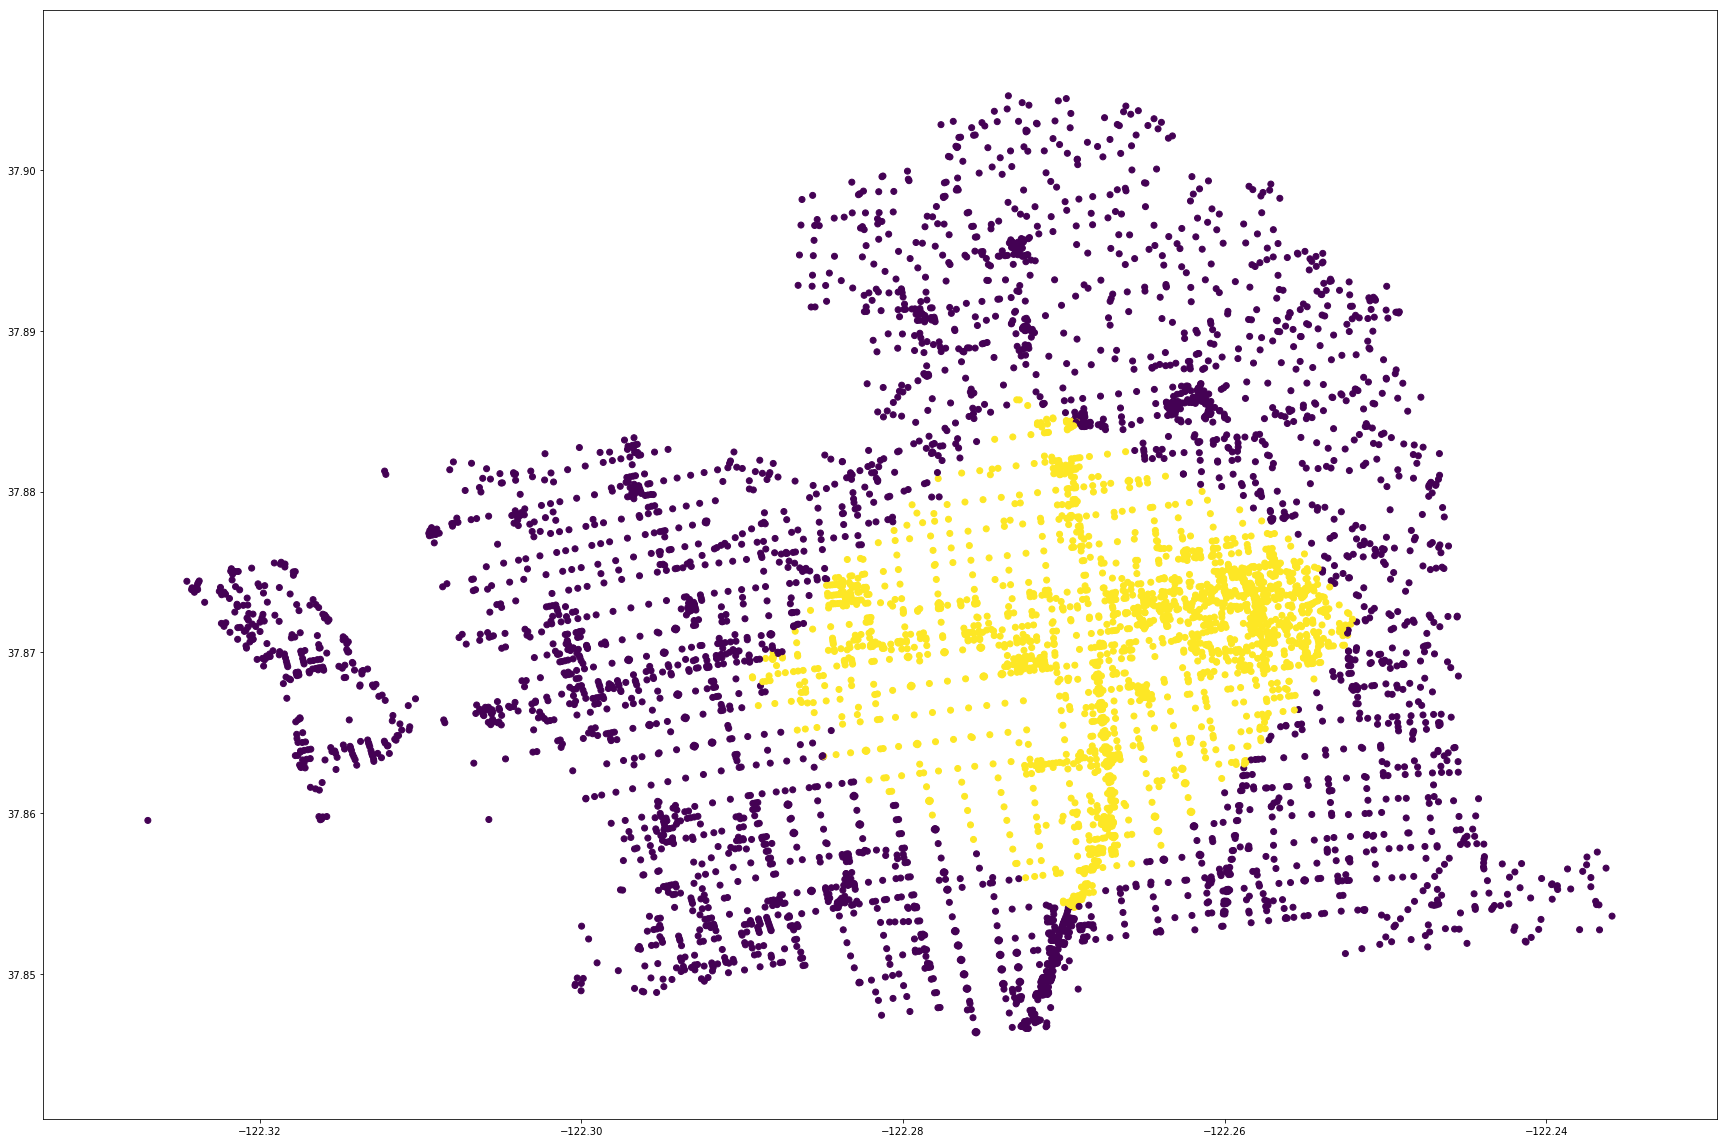

In [23]:
tmp_df = pd.DataFrame({"y": [37.87], "x": [-122.27], "value": [1.0]})
tmp_df["node_ids"] = net.get_node_ids(tmp_df.x, tmp_df.y)
net.set(tmp_df.node_ids, variable=tmp_df.value, name="tmp")
nodes["tmp"] = net.aggregate(1800, type="sum", decay="flat", name="tmp")
nodes.plot(figsize=(30, 25), column="tmp", legend=False)

## Another way to perform an average is network knn

Pandana has always had the feature to find the nearest K observations.  This can, e.g. be used to create Walkscore by combining a function of the distances to the nearest coffee shops, restaurants, etc.  Recently the feature was added to also return the node ids for the nearest K observations, which allows us to average the data at those locations.  This is analagous to the KNN (K nearest neighbors) algorithm, but along networks.

In [29]:
net.set_pois("redfin", 4000, 10, df.LONGITUDE, df.LATITUDE)
k = 10
results = net.nearest_pois(4000, "redfin", num_pois=k, include_poi_ids=True)
results.head()

1           2           3            4            5  \
34351114  268.584991  871.703979  943.229004  1208.770020  1252.151978   
34485314  227.188004  830.307007  901.831970  1167.373047  1210.755005   
35719055  344.408997  492.380005  711.471985   718.409973   767.966003   
35719092  344.753998  856.374023  987.120972  1284.938965  1328.321045   
35719098  103.813004  778.456970  837.729980  1043.998047  1087.380005   

                    6            7            8            9           10  \
34351114  1266.723022  1586.901978  1637.385986  1693.880005  1739.048950   
34485314  1225.326050  1545.505005  1595.989014  1652.483032  1697.651978   
35719055   912.229004  1055.849976  1074.359985  1091.125977  1116.875977   
35719092  1382.140015  1702.318970  1752.802979  1809.296997  1815.218018   
35719098  1232.749023  1526.286011  1574.276978  1603.411987  1648.387939   

                      poi1               poi2               poi3  \
34351114  2448 Prospect St   220 Stonewall Rd  161 Panoramic Way   
34485314  2448 Prospect St   220 Stonewall Rd  161 Panoramic Way   
35719055  220 Stonewall Rd      2932 Pine Ave       6 Nogales St   
35719092  2448 Prospect St  161 Panoramic Way   220 Stonewall Rd   
35719098  2448 Prospect St  161 Panoramic Way   220 Stonewall Rd   

                      poi4                poi5              poi6  \
34351114  2734 College Ave    2528 Chilton Way     2932 Pine Ave   
34485314  2734 College Ave    2528 Chilton Way     2932 Pine Ave   
35719055   2818 Webster St  102 El Camino Real  2734 College Ave   
35719092  2734 College Ave    2528 Chilton Way     2932 Pine Ave   
35719098  2734 College Ave    2528 Chilton Way     2932 Pine Ave   

                      poi7              poi8                poi9  \
34351114   2818 Webster St      6 Nogales St  102 El Camino Real   
34485314   2818 Webster St      6 Nogales St  102 El Camino Real   
35719055  139 Hillcrest Rd  2448 Prospect St     128 ALVARADO Rd   
35719092   2818 Webster St      6 Nogales St  102 El Camino Real   
35719098   2818 Webster St     2218 Blake St        6 Nogales St   

                    poi10  
34351114    2218 Blake St  
34485314    2218 Blake St  
35719055  2631 Webster St  
35719092    2218 Blake St  
35719098  2631 Webster St

#### Actually perform the average

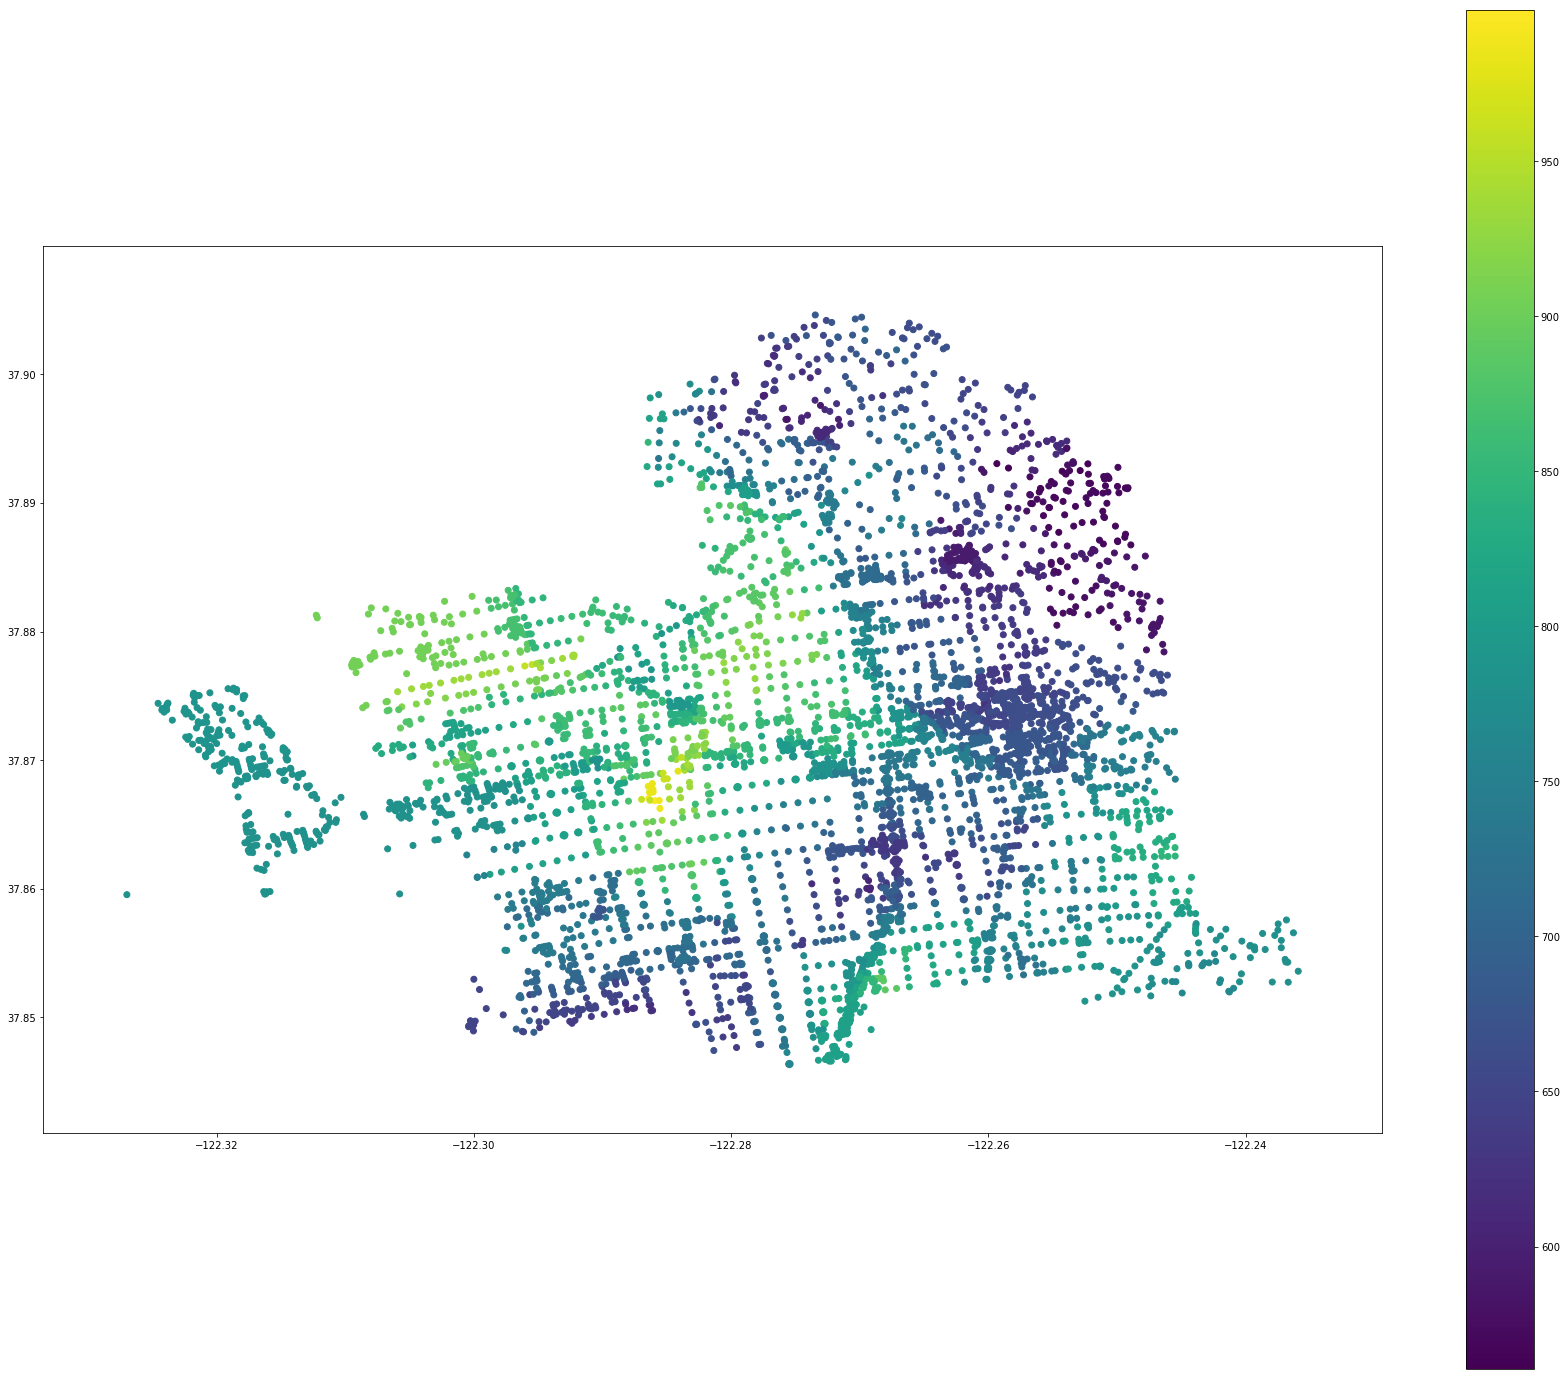

In [33]:
knn_values = pd.DataFrame()
for i in range(1, k+1):
    col = "poi%d" % i
    knn_values[col] = df.loc[results[col]]["$/SQUARE FEET"].values
s = knn_values.mean(axis=1)
filtered_nodes = nodes.loc[results.index]
filtered_nodes["knn_ave"] = s.values
filtered_nodes.plot(column="knn_ave", figsize=(30, 25), legend=True)

#### The same average as above just for comparison

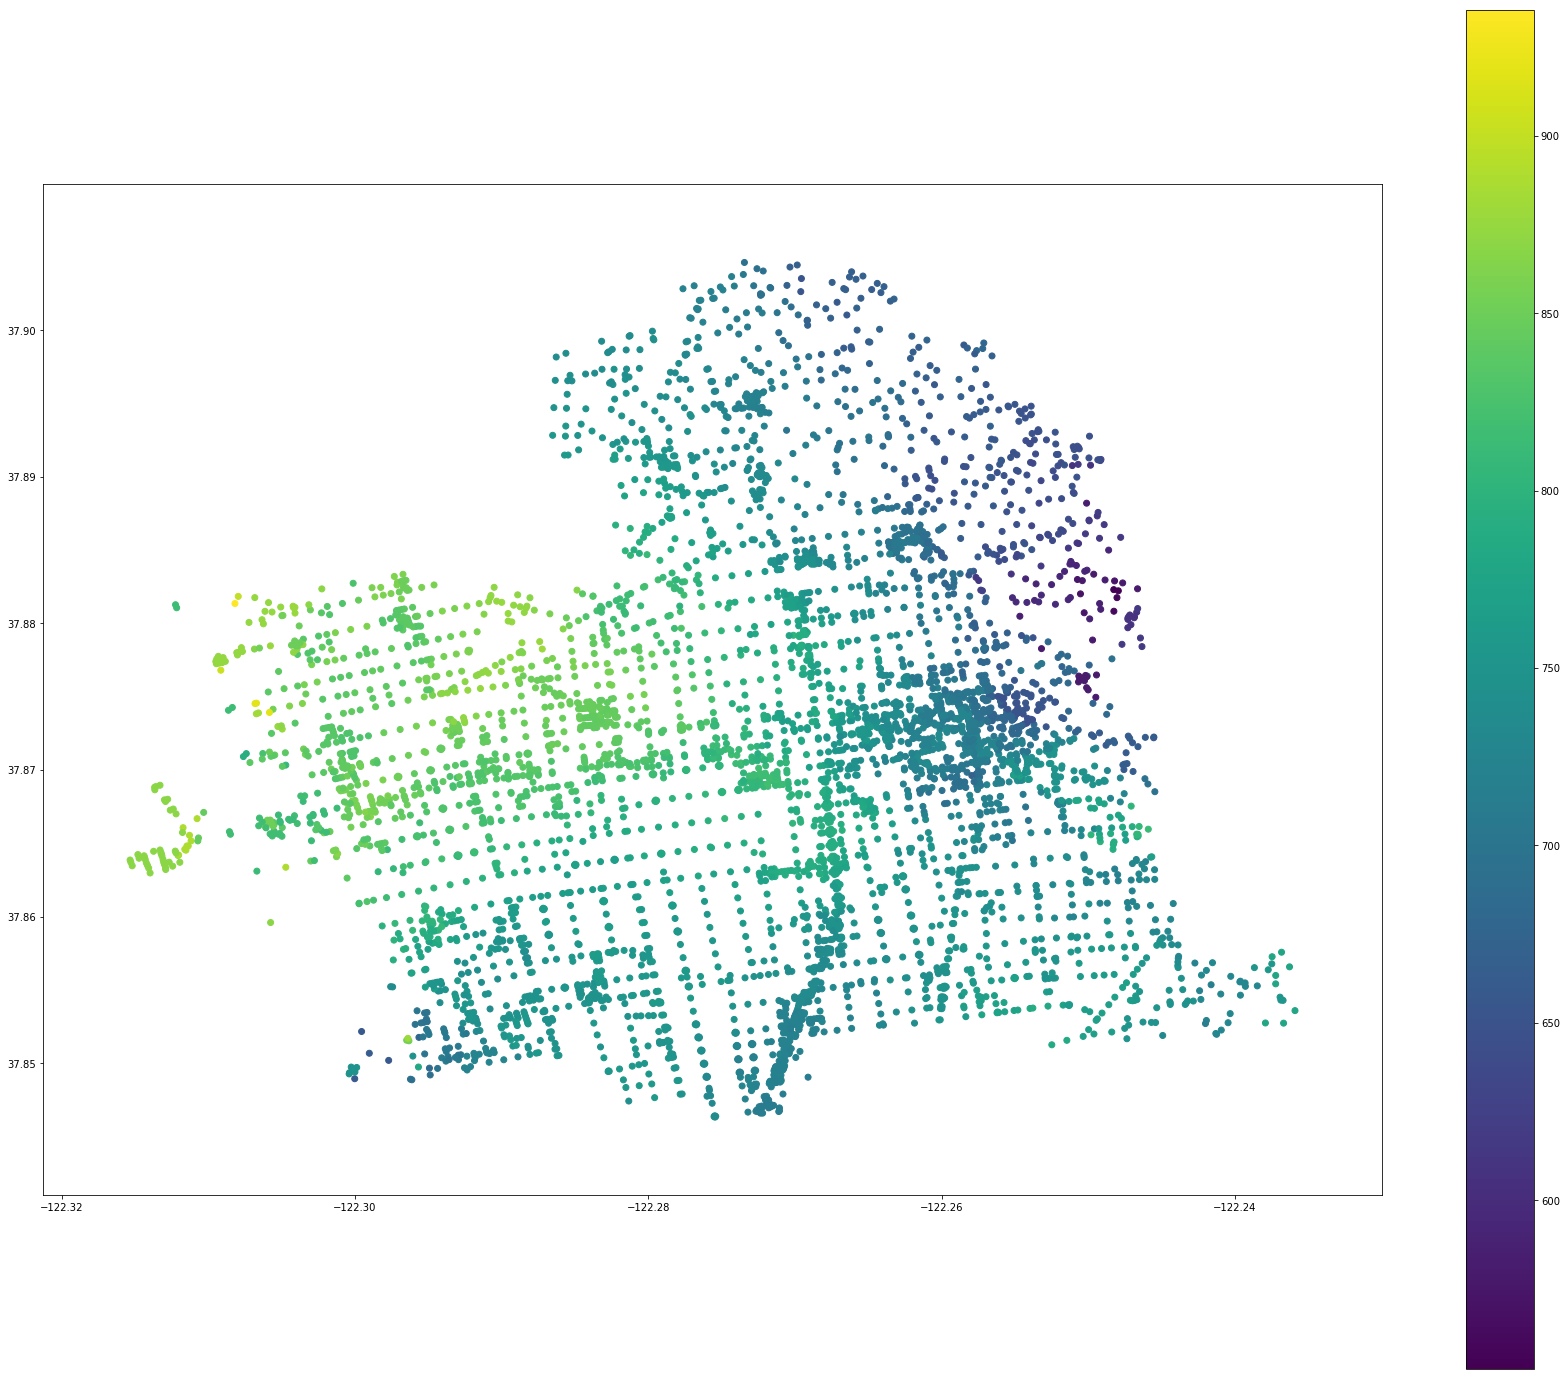

In [31]:
nodes[nodes["2000meters"] > 0].plot(figsize=(30, 25), column="2000meters", legend=True)